# An implementation of the CoordConv2D Layer in PyTorch

## Introduction

### What is a CoordConv2D Layer?

A CoordConv2D Layer is a custom CNN Layer that takes as input an image and generates as output the normalized 2D cartesian coordinate grid corresponding to the pixel locations of the input image. This layer is designed such that the shape of the output tensor of this layer is compatible with the shape of the input tensor of the standard Conv2D Layer in PyTorch. This compatibility requirement combined with the fact that the cartesian coordinates of a pixel location is a 2D vector, result in a "double channel" output - the "first channel" holding the "x coordinate" and the "second channel" holding the "y coordinate"

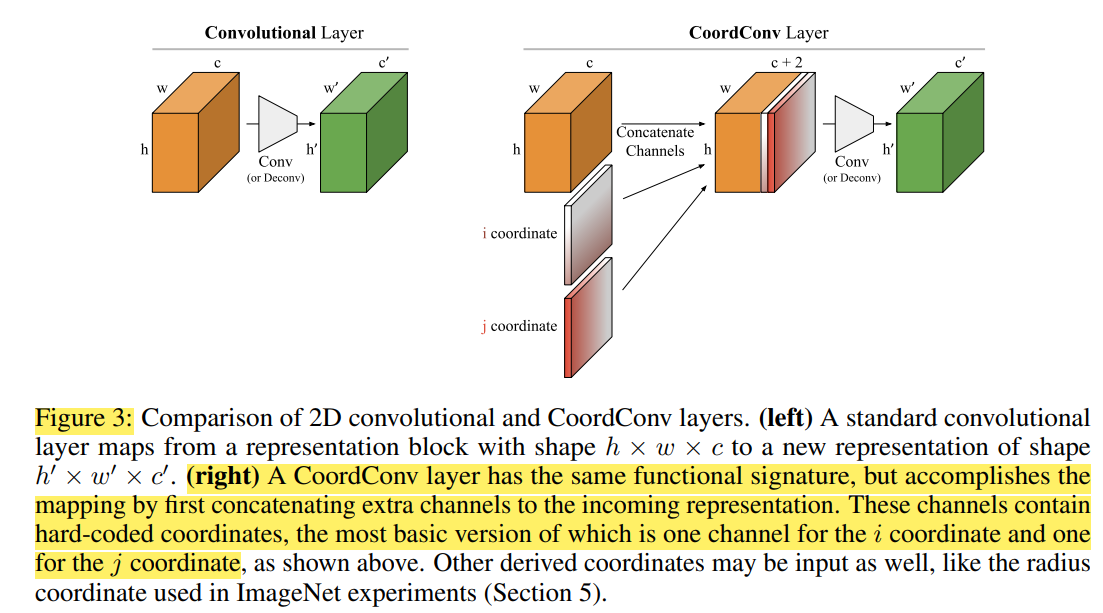

### Why do we need a CoordConv2D Layer?

#### In Theory?

Suppose that we have an image of a system and we are interested in trying to find the "cause" of that image. Let us assume that this cause is some "Physical Field" that depends on the locations of the pixels in the image. "Back-tracking" the "cause" is often times referred to as the "inverse problem" and the method used to solve this problem is referred to as the "inverse solver". Now, suppose a vanilla CNN is used as an inverse solver, although this might work well in practice, at a conceptual level, the CNN architecture does not incorporate spatial information in the form of cartesian coordinates, a fundamental idea used while describing Physical systems. If we are interested in Physical Fields that depend on the pixel location, it makes perfect sense, at least, in theory, that the information about the pixel locations must be incorporated into the CNN architecture

#### In Practice?

Although we argued that such a layer does make sense "in theory", it might not be strictly required "in practice", if the vanilla CNN inverse-solver performs well enough. We will first need to identify situations where the vanilla inverse-solver fails! This work is inspired by a paper titled: "An Intriguing Failing of Convolutional Neural Networks and the CoordConv solution". The title of this well-cited paper more than emphasizes the need for "fancier methods" only when "vanilla methods" fail! Therefore, it might be worth having the option to "switch ON and OFF" the CoordConv2D Layer so we can see the effect it has and if it improves recovery in scenarios where the vanilla inverse-solver fails. The other motivation behind having this layer is that we are trying to implement a modified version of the NN architecture for a Physics-based inverse solver from Katie Bouman's paper where she argues that such a layer is very powerful while solving Physics-based inverse problems for recovering optical fields. In Katie's NN implementation, the coordinate-based layer is the very first layer and thus, if we are following along, implementing it is the very first step that we must take! That is another reason that we are implementing this layer

#### Link to Katie Bouman's paper

https://arxiv.org/abs/2309.04437

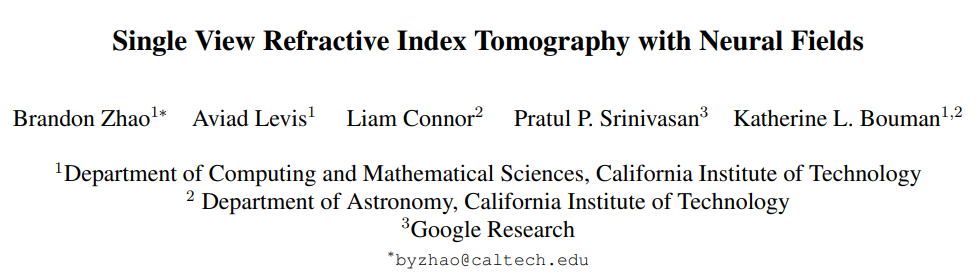

## Points to note

1. Implementations of Physics-based CNN architectures involving "complex-valued fields" can be carried out using variants of the CoordConv2D Layer
2. There are a lot of applications of the CoordConv2D Layers outside Physics. The original paper has a Tensorflow implementation. Given the number of applications, having a PyTorch code template for the CoordConv2D Layer might be of value

## Who inspired this exercise?

1. This exercise was inspired by the paper titled: "An Intriguing Failing of Convolutional Neural Networks and the CoordConv Solution"
2. The Link to this paper is attached below

### Link to the CoordConv paper

https://arxiv.org/abs/1807.03247v2

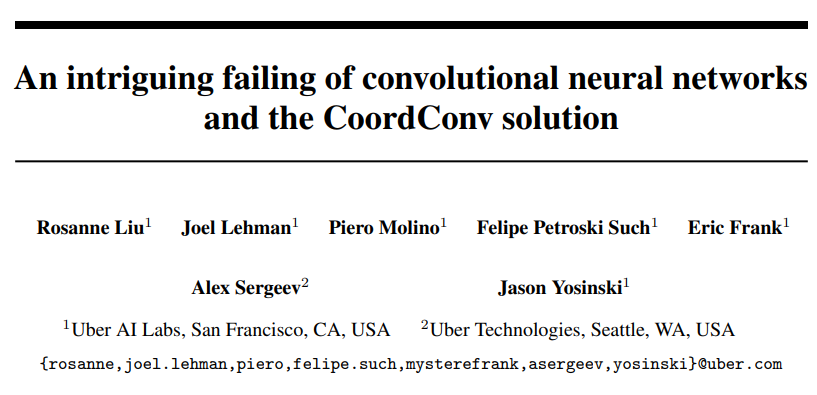

## Import relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms

## Download and load MNIST dataset

In [2]:
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
sample_image, label = mnist_train[0]

We need a sample image to apply our CoordConv2DLayer on. Therefore, we are loading the MNIST dataset so that we can extract a sample image

## Define CoordConv2D Layer

In [3]:
class CoordConv2DLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_tensor):
        _, height, width = input_tensor.size()

        # Create x and y coordinate grids
        xx_channel = torch.arange(width).view(1, 1, 1, width).expand(1, 1, height, width).float() / (width - 1)
        yy_channel = torch.arange(height).view(1, 1, height, 1).expand(1, 1, height, width).float() / (height - 1)

        # Concatenate the coordinate channels to the input tensor
        output_tensor = torch.cat([xx_channel, yy_channel], dim=1)
        return output_tensor

## Explanation of code block in the forward pass of the CoordConv2D Layer

1. torch.arange(coordinate_size) generates a 1D array ranging from 0 to 'coordinate_size - 1' where 'coordinate_size' = {width, height}
2. torch.view reshapes the tensor so that it has additional dimensions for batch size, channel and the other dimension
3. torch.expand expands the dimensions so that the row/column vector is replicated "n" times where n = the value of the other dimension
4. torch.float converts the "dtype" of the torch tensor to float. Conversion to float ensures compatibility for operations with other float tensors
5. division by 'coordinate_size - 1' results in a "normalized coordinate". Normalization is always good practice while working with Machine Learning problems and gets rid of potential "scaling issues"
6. torch.cat concatenates torch tensors and the "dim = 1" ensures that the concatenation combines two "single channel" tensors into a one "double channel" tensor
7. all the code lines in the forward pass of the CoordConv2D Layer will be demonstrated step by step below

In [4]:
_, height_demonstrate, width_demonstrate = sample_image.size()

In [5]:
height_demonstrate

28

In [6]:
width_demonstrate

28

In [7]:
xx_channel_demonstrate = torch.arange(width_demonstrate)

torch.arange(coordinate_size) generates a 1D array ranging from 0 to 'coordinate_size - 1' where 'coordinate_size' = {width, height}

In [8]:
xx_channel_demonstrate.shape

torch.Size([28])

In [9]:
torch.min(xx_channel_demonstrate)

tensor(0)

In [10]:
torch.max(xx_channel_demonstrate)

tensor(27)

In [11]:
xx_channel_demonstrate = xx_channel_demonstrate.view(1, 1, 1, width_demonstrate)

torch.view reshapes the tensor so that it has additional dimensions for batch size, channel and the other dimension

In [12]:
xx_channel_demonstrate.shape

torch.Size([1, 1, 1, 28])

In case of the xx_channel_demonstrate, we get a row vector with 3 additional dimensions

In [13]:
xx_channel_demonstrate = xx_channel_demonstrate.expand(1, 1, height_demonstrate, width_demonstrate)

torch.expand expands the dimensions so that the xx_channel_demonstrate row vector is replicated "n" times where n = height. This creates a matrix of dimensions height times width where the row vector with a varying x-coordinate is replicated "height" number of times

In [14]:
xx_channel_demonstrate.shape

torch.Size([1, 1, 28, 28])

In [15]:
xx_channel_demonstrate = xx_channel_demonstrate.float()

torch.float converts the "dtype" of the torch tensor to float

In [16]:
xx_channel_demonstrate.dtype

torch.float32

In [17]:
xx_channel_demonstrate = xx_channel_demonstrate / (width_demonstrate - 1)

division by 'coordinate_size - 1' results in a "normalized coordinate"

In [18]:
torch.min(xx_channel_demonstrate)

tensor(0.)

In [19]:
torch.max(xx_channel_demonstrate)

tensor(1.)

## Apply the Coordinate Layer to the sample MNIST digit input

In [20]:
coordinate_layer = CoordConv2DLayer()
output_with_coords = coordinate_layer(sample_image)

## Extract X and Y channels

### Start by understanding the anatomy of the output torch tensor

In [21]:
output_with_coords.shape

torch.Size([1, 2, 28, 28])

1. The torch shape array has 4 dimensions
2. The various dimension of the torch tensor have the following meaning:
    1. Dimension 1: Batch size
    2. Dimension 2: Number of channels
    3. Dimension 3: Number of rows
    4. Dimension 4: Number of columns
3. This torch shape is consistent with the inputs required for a Conv2d layer in PyTorch
4. The x-channel corresponds to the "0" element for Dimension 2 and "all elements" in the other dimensions
5. The y-channel corresponds to the "1" element for Dimension 2 and "all elements" in the other dimensions

### Extract the channels

In [22]:
x_channel = output_with_coords[:, 0, :, :]
y_channel = output_with_coords[:, 1, :, :]

### Check shapes of X and Y channels

In [23]:
x_channel.shape

torch.Size([1, 28, 28])

In [24]:
y_channel.shape

torch.Size([1, 28, 28])

1. The x channels and y channels have the "channel dimension"
2. This "redundant dimension" needs to be removed for plotting
3. We will apply the squeeze() operation to remove the redundant dimension
4. We will also convert the torch tensors into numpy arrrays as many visualization libraries work well with numpy arrays

### Transform channel data for display

In [25]:
x_channel_plot = x_channel.squeeze().numpy()
y_channel_plot = y_channel.squeeze().numpy()

In [26]:
np.max(x_channel_plot)

1.0

In [27]:
np.min(x_channel_plot)

0.0

### Check shape and type of display arrays

In [28]:
print(x_channel_plot.shape, type(x_channel_plot))
print(y_channel_plot.shape, type(y_channel_plot))

(28, 28) <class 'numpy.ndarray'>
(28, 28) <class 'numpy.ndarray'>


## Visualize CoordConv Layer

Text(0.5, 1.0, 'Y channel')

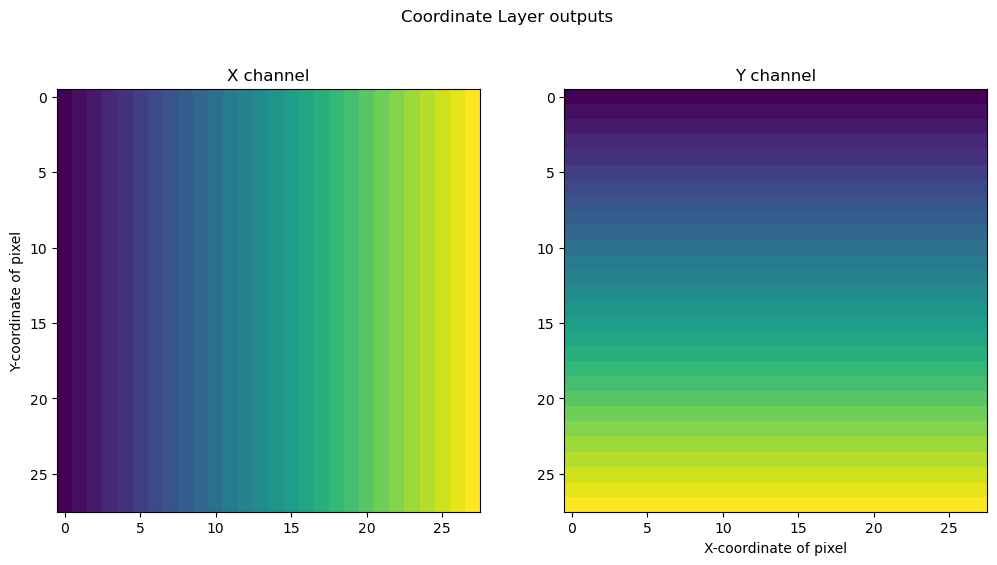

In [29]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Coordinate Layer outputs")

ax_1.imshow(x_channel_plot, cmap='viridis')
ax_1.set_ylabel('Y-coordinate of pixel')
ax_1.set_title('X channel')

ax_2.imshow(y_channel_plot, cmap='viridis')
ax_2.set_xlabel('X-coordinate of pixel')
ax_2.set_title('Y channel')

## Future work

1. Go through the citations of the CoordConv paper to see if it has been used for an application relevant to our problem. If no one has done this for an application relevant to our problem, that might count as a novelty factor
2. Although NNs use a coordinate grid during "learning", their power comes from the fact that they learn the "mapping" from the coordinates to the Physical Field and this mapping can be then applied to "untrained coordinates" whereas standard "grid-based" solvers "simply interpolate". Future work should consider comparing our PINN solver to other "grid-based" solvers
3. Speaking of NN as an inverse solver, as of now, we don't know how our NN solver compares with typical inverse solvers for problems of our interest. Future work should consider a comparison between our NN-based inverse solvers and other typical inverse solvers, for instance, a "gold-standard" inverse solver for such problems, if one exists!